In [1]:
%run ./PPS_Expansion_Model.ipynb

/home/renato-paredes/.virtualenvs/gifted/lib/python3.13/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In this notebook I apply different methodologies used across the literature to model SCZ. I specifically look at how parameter changes in the neurobiological network influence the psychometric function - i.e., the values of the Central Point and the Slope. I also come up with my own exploration of cross-modal links and their influence on schizophrenia.

In [2]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
s_distances_sec = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - s_distances_sec * v  # distance points in cm (network coordinates)

simtime = 200.0
ts = 0.4

### 1) Exploring E/I Imbalance

The most reliable neurobiological marker of schizophrenia is reduced GABAergic inhibition intraregionally, which I model through either excessive $L_{ex}^s$ values

In [3]:
# Start by building the inflexible parameters

# feedforward and feedback
Wt, Wa, Wv, Bt, Ba, Bv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=1.289e01,
    k2=7.552e02,
    lim=3.674e01,
    alpha=9.797e-01,
)

# cross-modal
Wat, Wvt, Wav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)

In [4]:
LEXs = np.linspace(0.15, 3.65, 10)
LRTs = np.zeros((len(LEXs), len(a_distances)))

for i in range(len(LEXs)):
    Lt, La, Lv = Lw(
        Lex_t=LEXs[i],
        Lin_t=0.05,
        sigmaex_t=1,
        sigmain_t=4,
        Lex_a=LEXs[i],
        Lin_a=0.05,
        sigmaex_a=20,
        sigmain_a=80,
        Lex_v=LEXs[i],
        Lin_v=0.05,
        sigmaex_v=1,
        sigmain_v=4,
    )

    _, _, _, _, LRTs[i, :] = experiment(
        ts=ts,
        T=simtime,
        dist=a_distances,
        ya=5,
        Lt=Lt,
        La=La,
        Lv=Lv,
        Wt=Wt,
        Wa=Wa,
        Wv=Wv,
        Bt=Bt,
        Ba=Ba,
        Bv=Bv,
        Wat=Wat,
        Wvt=Wvt,
        Wav=Wav,
        FWpr=0,
        CMpr=0,
    )

In [5]:
Lcp = np.zeros(len(LEXs))
Lslope = np.zeros(len(LEXs))

for i in range(len(LEXs)):
    RTs = LRTs[i, :]

    ymin = np.min(RTs)
    ymax = np.max(RTs)

    Lcp[i], Lslope[i] = fitting(a_distances, RTs)

np.save("drafts/Lcp.npy", Lcp)
np.save("drafts/Lslope.npy", Lslope)
np.save("drafts/LRT.npy", LRTs)

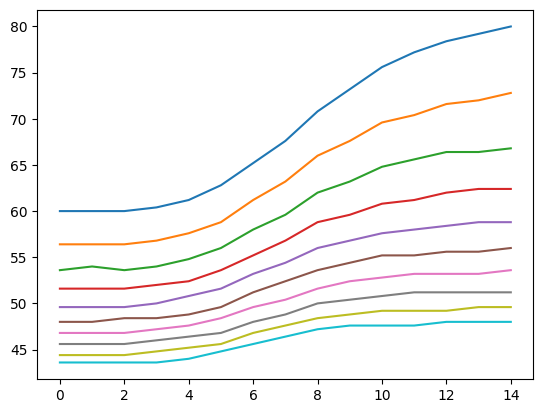

In [6]:
plt.plot(LRTs.T)

### 2)Exploring FW Pruning

Another straightforward method in the literature is synaptic pruning of feedforward weights from the unisensory regions into the multisensory neuron. 

In [7]:
Lt, La, Lv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)


# feedforward and feedback
Wt, Wa, Wv, Bt, Ba, Bv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=1.289e01,
    k2=7.552e02,
    lim=3.674e01,
    alpha=9.797e-01,
)

# cross-modal
Wat, Wvt, Wav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)

In [8]:
PRs = np.linspace(0, 6.5, 10)
PRRTs = np.zeros((len(PRs), len(a_distances)))

for i in range(len(PRs)):
    _, _, _, _, PRRTs[i, :] = experiment(
        ts=ts,
        T=simtime,
        dist=a_distances,
        ya=5,
        Lt=Lt,
        La=La,
        Lv=Lv,
        Wt=Wt,
        Wa=Wa,
        Wv=Wv,
        Bt=Bt,
        Ba=Ba,
        Bv=Bv,
        Wat=Wat,
        Wvt=Wvt,
        Wav=Wav,
        FWpr=PRs[i],
        CMpr=0,
    )

In [9]:
PRcp = np.zeros(len(PRs))
PRslope = np.zeros(len(PRs))

for i in range(len(PRs)):
    RTs = PRRTs[i, :]

    ymin = np.min(RTs)
    ymax = np.max(RTs)

    PRcp[i], PRslope[i] = fitting(a_distances, RTs)

np.save("drafts/PRcp.npy", PRcp)
np.save("drafts/PRslope.npy", PRslope)
np.save("drafts/PRRT.npy", PRRTs)

### 3)Exploring B_0

Paredes et al., 2021 further eplore top-down signalling issues, which they end up removing from their end model. Since my model includes crossmodal connectivity, this exploration could be of use

In [10]:
# Start by building the inflexible parameters

# cross-modal
Wat, Wvt, Wav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)

# lateral
Lt, La, Lv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

In [11]:
FBs = np.linspace(2.5, 10.5, 10)
BRTs = np.zeros((len(FBs), len(a_distances)))

for i in range(len(FBs)):
    Wt, Wa, Wv, Bt, Ba, Bv = FwFb(
        Wt_0=6.5,
        Wa_0=6.5,
        Wv_0=6.5,
        Bt_0=FBs[i],
        Ba_0=FBs[i],
        Bv_0=FBs[i],
        k1=1.289e01,
        k2=7.552e02,
        lim=3.674e01,
        alpha=9.797e-01,
    )

    _, _, _, _, BRTs[i, :] = experiment(
        ts=ts,
        T=simtime,
        dist=a_distances,
        ya=5,
        Lt=Lt,
        La=La,
        Lv=Lv,
        Wt=Wt,
        Wa=Wa,
        Wv=Wv,
        Bt=Bt,
        Ba=Ba,
        Bv=Bv,
        Wat=Wat,
        Wvt=Wvt,
        Wav=Wav,
        FWpr=0,
        CMpr=0,
    )

In [12]:
Bcp = np.zeros(len(FBs))
Bslope = np.zeros(len(FBs))

for i in range(len(FBs)):
    RTs = BRTs[i, :]

    ymin = np.min(RTs)
    ymax = np.max(RTs)

    Bcp[i], Bslope[i] = fitting(a_distances, RTs)

np.save("drafts/Bcp.npy", Bcp)
np.save("drafts/Bslope.npy", Bslope)
np.save("drafts/BRT.npy", BRTs)

### 4) Exploring CM Pruning

In [13]:
Lt, La, Lv = Lw(
    Lex_t=0.15,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=0.15,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=0.15,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)

Wt, Wa, Wv, Bt, Ba, Bv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=1.289e01,
    k2=7.552e02,
    lim=3.674e01,
    alpha=9.797e-01,
)

Wat, Wvt, Wav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)

In [14]:
CM_PRs = np.linspace(0, 0.05, 10)
CM_PRRTs = np.zeros((len(CM_PRs), len(a_distances)))

for i in range(len(CM_PRs)):
    _, _, _, _, CM_PRRTs[i, :] = experiment(
        ts=ts,
        T=simtime,
        dist=a_distances,
        ya=5,
        Lt=Lt,
        La=La,
        Lv=Lv,
        Wt=Wt,
        Wa=Wa,
        Wv=Wv,
        Bt=Bt,
        Ba=Ba,
        Bv=Bv,
        Wat=Wat,
        Wvt=Wvt,
        Wav=Wav,
        FWpr=0,
        CMpr=CM_PRs[i],
    )

In [15]:
CM_PRcp = np.zeros(len(PRs))
CM_PRslope = np.zeros(len(PRs))

for i in range(len(PRs)):
    RTs = CM_PRRTs[i, :]

    ymin = np.min(RTs)
    ymax = np.max(RTs)

    CM_PRcp[i], CM_PRslope[i] = fitting(a_distances, RTs)

np.save("drafts/CM_PRcp.npy", CM_PRcp)
np.save("drafts/CM_PRslope.npy", CM_PRcp)
np.save("drafts/CM_PRRT.npy", CM_PRcp)

### Plots

In [16]:
# Alternatively, if you have the numpy objects and dont want to check for yourself

# Lcp = np.load("drafts/Lcp.npy")
# Lslope = np.load("drafts/Lslope.npy")
# LRTs = np.load("drafts/LRT.npy")

# Bcp = np.load("drafts/Bcp.npy")
# Bslope = np.load("drafts/Bslope.npy")
# BRTs = np.load("drafts/BRT.npy")

# PRcp = np.load("drafts/PRcp.npy")
# PRslope = np.load("drafts/PRslope.npy")
# PRRTs = np.load("drafts/PRRT.npy")

# CM_PRcp = np.load("drafts/CM_PRcp.npy")
# CM_PRslope = np.load("drafts/CM_PRslope.npy")
# CM_PRRT = np.load("drafts/CM_PRRT.npy")

# CMcp = np.load("drafts/CMcp.npy")
# CMslope = np.load("drafts/CMslope.npy")
# CMRTs = np.load("drafts/CMRT.npy")

In [20]:
CMs = np.linspace(0, 1, 10)

SCZ data
CP: 50.02
Slope 13.333333333333334


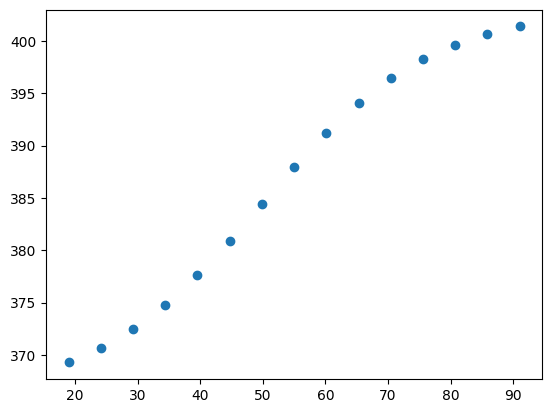

In [18]:
##Pre-Training
###SCZ patients
ymin = 366
ymax = 403
scz_cp = 100 - 1.666 * 30
scz_slope = 1 / 0.075

SCZ_RTs = RTsig(a_distances, scz_cp, scz_slope)

print("SCZ data")
print("CP:", scz_cp)
print("Slope", scz_slope)
plt.scatter(a_distances, SCZ_RTs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


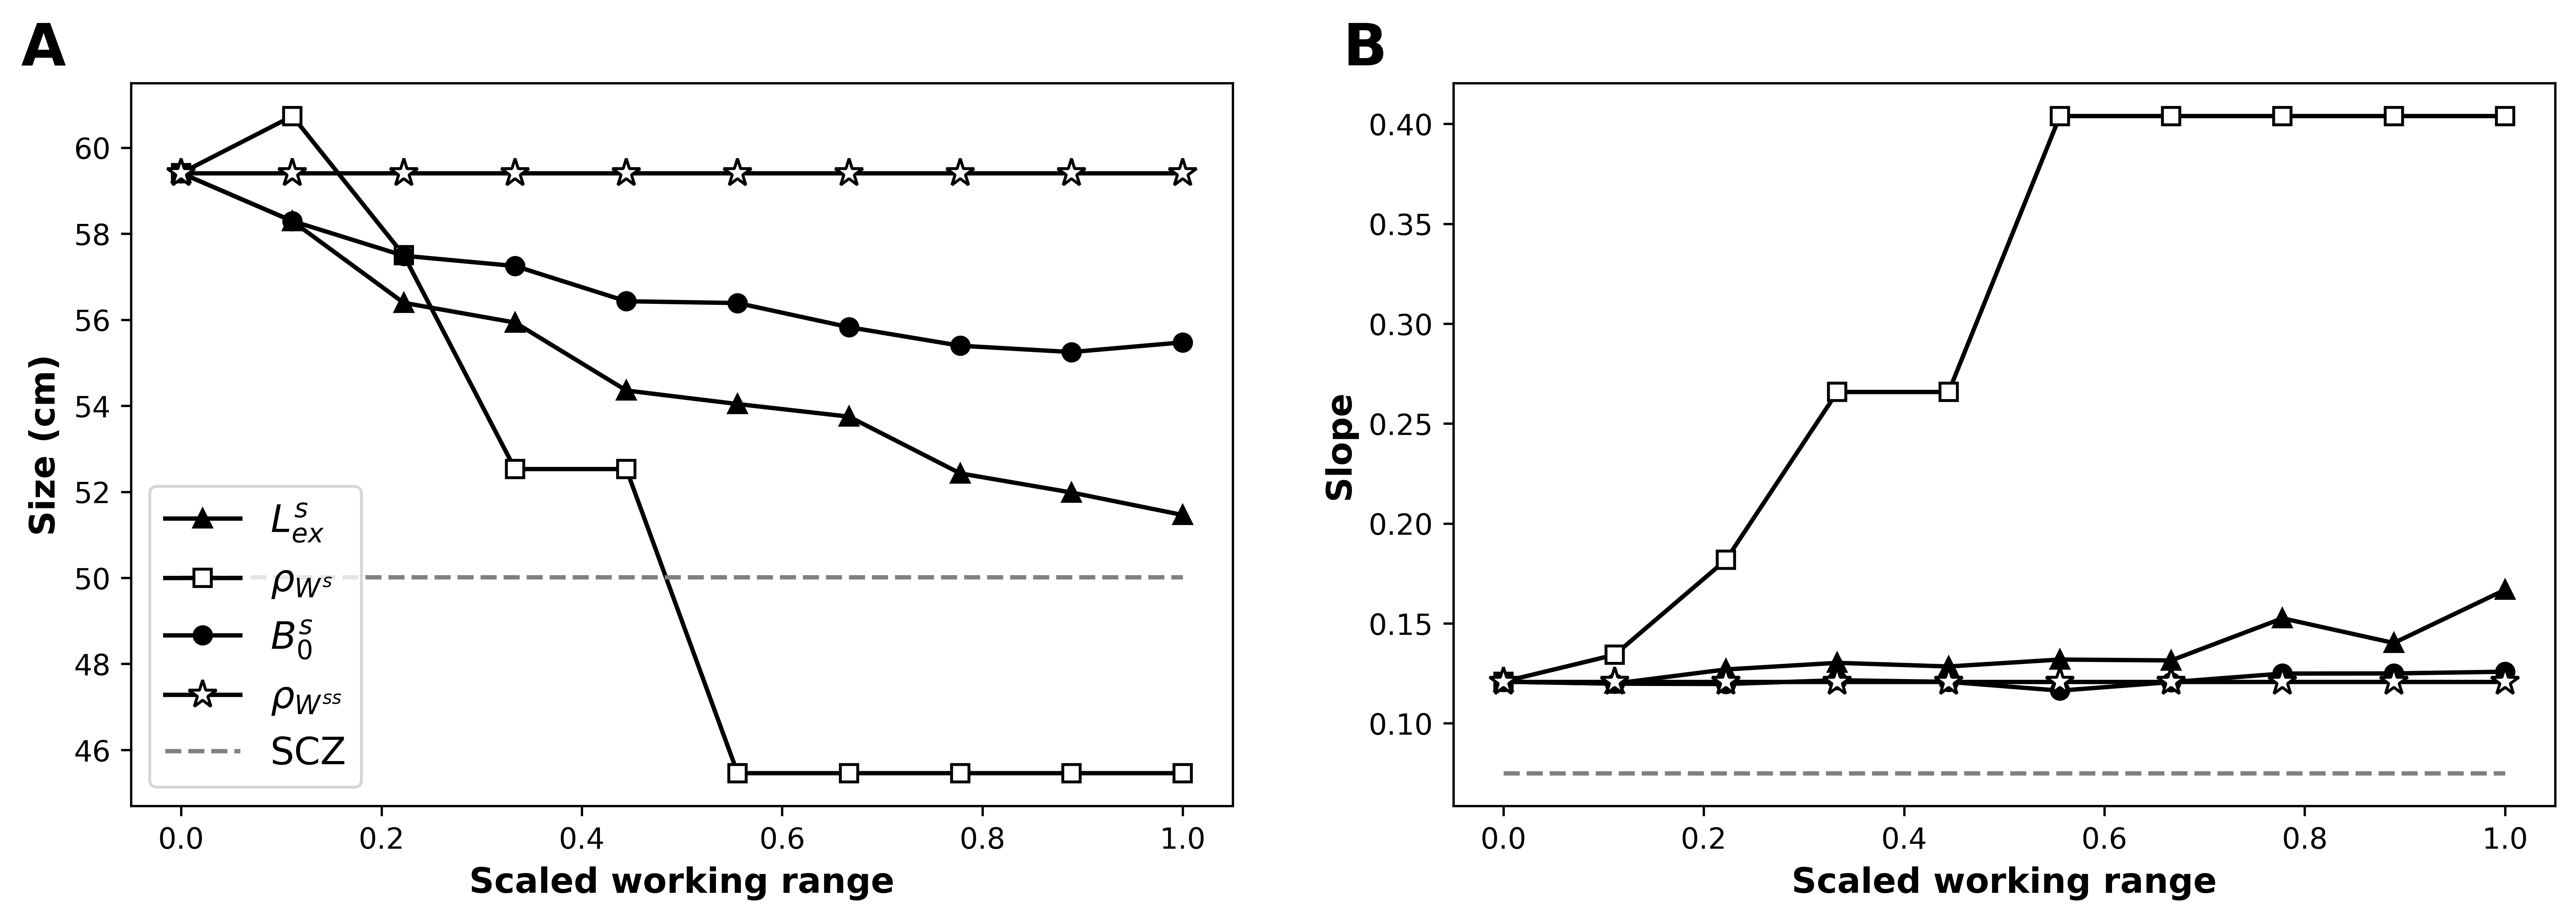

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4.5), dpi=600)

ax1 = plt.subplot(121)
ax1.plot(CMs, Lcp, label=r"$L_{ex}^{s}$", color="k", marker="^")
ax1.plot(
    CMs,
    PRcp,
    label=r"$\rho_{{W}^{s}}$",
    color="k",
    marker="s",
    markerfacecolor="white",
)
ax1.plot(CMs, Bcp, label=r"$B_{0}^{s}$", color="k", marker="o")
ax1.plot(
    CMs,
    CM_PRcp,
    label=r"$\rho_{{W}^{ss}}$",
    color="k",
    marker="*",
    markerfacecolor="white",
    markersize=10,
)
ax1.plot(CMs, np.repeat(scz_cp, len(CMs)), "--", label="SCZ", color="0.5")
ax1.set_ylabel("Size (cm)", size=12, weight="bold")
ax1.set_xlabel("Scaled working range", size=12, weight="bold")
leg = ax1.legend(fontsize=13)
ax1.text(
    -0.1,
    1.025,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax2 = plt.subplot(122)
ax2.plot(CMs, 1 / Lslope, label=r"$L_{ex}^{s}$", color="k", marker="^")
ax2.plot(
    CMs,
    1 / PRslope,
    label=r"$\rho_{{W}^{s}}$",
    color="k",
    marker="s",
    markerfacecolor="white",
)
ax2.plot(CMs, 1 / Bslope, label=r"$B_{0}^{s}$", color="k", marker="o")
ax2.plot(
    CMs,
    1 / CM_PRslope,
    label=r"$\rho_{{W}^{ss}}$",
    color="k",
    marker="*",
    markerfacecolor="white",
    markersize=10,
)
ax2.plot(CMs, np.repeat(1 / scz_slope, len(LEXs)), "--", label="SCZ", color="0.5")
ax2.set_ylabel("Slope", size=12, weight="bold")
ax2.set_xlabel("Scaled working range", size=12, weight="bold")
leg = ax2.legend(fontsize=13)
ax2.text(
    -0.1,
    1.025,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

ax2.get_legend().remove()
fig.savefig("drafts/FIG2.eps", bbox_inches="tight", format="eps")